In [3]:
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pandas as pd
import shap
import sys
from functions import *
import warnings
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
plt.ioff()

In [4]:
# Create a colour map

colors = ['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c']
cmap = ListedColormap(colors)

In [5]:
# Load model hyperparameters
hyperparameters_df = pd.read_csv("outputs/best_hyperparameters.csv")
hyperparameters_dict = hyperparameters_df.set_index('state').T.to_dict()

results_dict = {"State":[], "R Value":[], "Number of Trees":[]}

feature_names = feature_names_xai

State: Andhra_Pradesh
RMSE: 19.32379640332346
SN: 0.5614702650975292
LinregressResult(slope=0.6143098116183777, intercept=-0.3298399064902999, rvalue=0.832992370000415, pvalue=1.5259282173983356e-136, stderr=0.017842021940536988, intercept_stderr=0.6142057193239051)
--------------------------------------------------
State: Arunachal_Pradesh
RMSE: 0.23480368377539784
SN: 0.939917930851442
LinregressResult(slope=0.1306419537446075, intercept=0.00965150133207113, rvalue=0.3439283554219798, pvalue=5.0485045660820845e-16, stderr=0.015596513725057852, intercept_stderr=0.0039053739343044218)
--------------------------------------------------
State: Assam
RMSE: 8.387376664822414
SN: 0.5461671401834803
LinregressResult(slope=0.6678534432833091, intercept=-0.6462193484106561, rvalue=0.8389851118852147, pvalue=2.5179719475556575e-140, stderr=0.0189407946120328, intercept_stderr=0.2915907286130102)
--------------------------------------------------
State: Bihar
RMSE: 72.98323911525442
SN: 0.751569

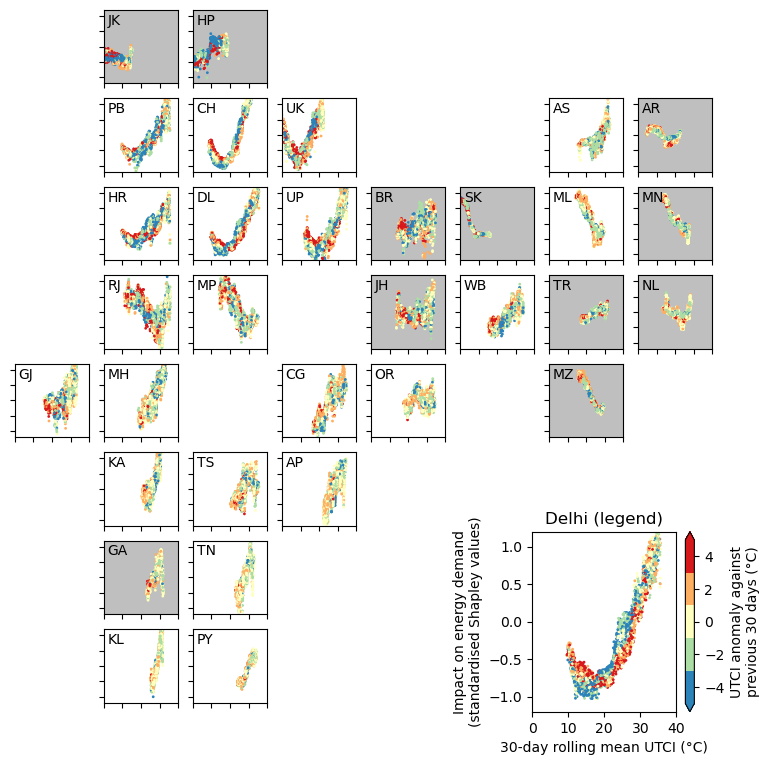

In [6]:
# Train a stripped back UTCI-only model for each state
# We use this to more closely inspect the effects of heat stress on demand

fig, ax_dict = plot_states_by_grid()
legend_ax = fig.add_axes([.7, .1, .2, .2])

n = 0

for state, subdiv in states_subdiv_mapping.items():
	n+=1
	
	
	df, df_energy = load_data(state)
	df = process_data(df, df_energy, subdiv)
	df = df[feature_names + ['date', 'energy_met_MU']]
	df = df.dropna()

	
	ax_name = state.replace("_", " ").replace("and ", "& ")
	
	X = df[feature_names]
	y = df['energy_met_MU']
	
	best_params = hyperparameters_dict[state]
	
	xg_reg, X_test, y_test, preds = train_model(X, y, df, best_params)
	r_value, n_trees = evaluate_model(xg_reg, X_test, y_test, preds, state=state)

	explainer = shap.Explainer(xg_reg)
	shap_values = explainer(X)
	
	idx = feature_names.index("rolling_avg_30d_utci_mean")
	idz = feature_names.index("anomaly_against_30d_utci_mean")
	
	base = y.std()
	data = shap_values.data[:, idx]-273.15
	vals = shap_values.values[:, idx]/base
	z = shap_values.data[:, idz]

	try:
		ax = ax_dict[ax_name]
	except: continue
	ax.scatter(data, vals, c=z, cmap=cmap, s=1, vmin=-5, vmax=5, rasterized=True)
	ax.set_ylim([-1.2,1.2])
	ax.set_xlim([0,40])
	ax.set_xticks(np.arange(0,45,10))
	ax.set_xticklabels([])
	ax.set_yticks(np.arange(-1, 1.5, 0.5))
	ax.set_yticklabels([])
	ax.text(0.05, 0.95, subdiv, ha='left', va='top', transform=ax.transAxes)

	if r_value**2 < 0.5:
		ax.patch.set_facecolor('grey') # grey out models that can't explain at least 50% of the variance
		ax.patch.set_alpha(0.5)

	if state == "NCT_of_Delhi":
		
		sc = legend_ax.scatter(data, vals, c=z, cmap=cmap, s=1, vmin=-5, vmax=5)
		legend_ax.set_title("Delhi (legend)")
		legend_ax.set_xlabel("30-day rolling mean UTCI (\u00B0C)")
		legend_ax.set_ylabel("Impact on energy demand\n(standardised Shapley values)")
		
		legend_ax.set_ylim([-1.2,1.2])
		legend_ax.set_xlim([0,40])
		legend_ax.set_xticks(np.arange(0,45,10))
		legend_ax.set_yticks(np.arange(-1, 1.5, 0.5))
		
		cb = plt.colorbar(sc, ax=legend_ax, extend='both')
		cb.set_label("UTCI anomaly against\nprevious 30 days (\u00B0C)")

	
	
plt.show()
